# 07-2 심층 신경망

## 2개의 층

다시 케라스 API를 사용해서 패션 MNIST 데이터셋을 불러오겠습니다.

In [2]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [3]:
from sklearn.model_selection import train_test_split
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

이제 인공 신경망 모델에 층을 2개 추가해 보겠습니다.

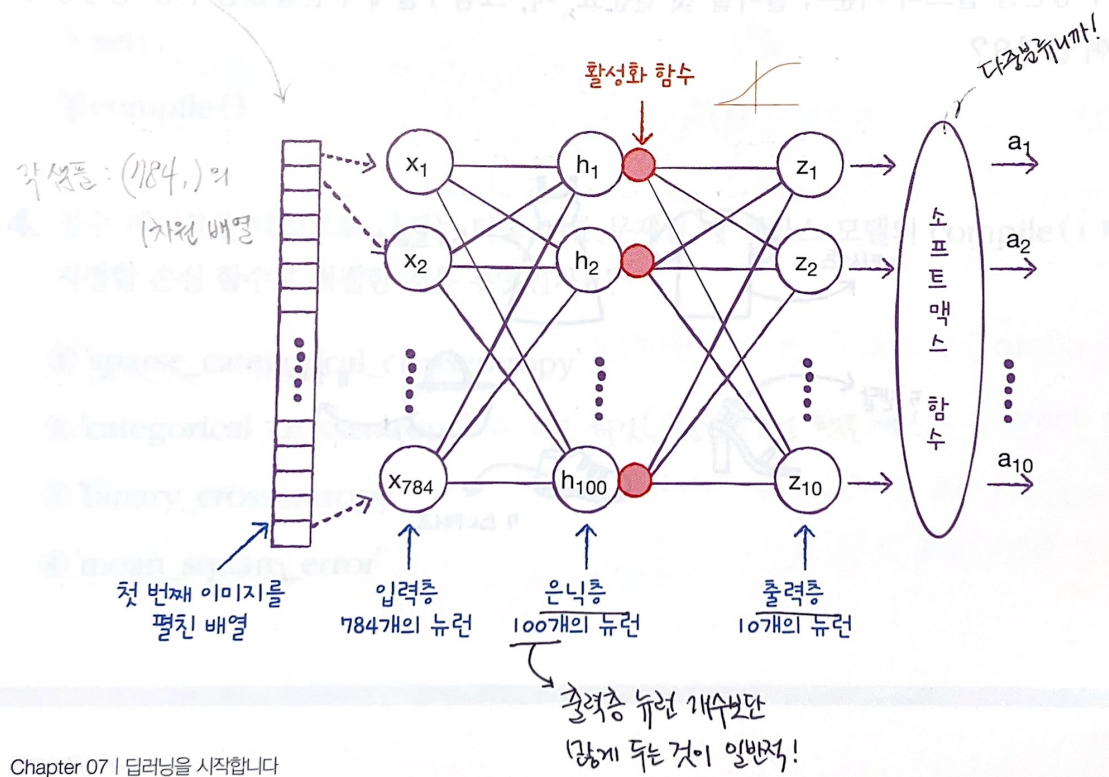

입력층과 출력층 사이에 있는 모든 층을 **은닉층**hidden layer이라고 부릅니다.

활성화 함수는 신경망 층의 선형 방정식의 계산 값에 적용하는 함수입니다. 이전 절에서 출력층에 적용했던 소프트맥스 함수도 활성화 함수입니다. 출력층에 적용하는 활성화 함수는 종류가 제한되어 있습니다. 이진 분류일 경우 시그모이드 함수를 사용하고 다중 분류일 경우 소프트맥스 함수를 사용하죠. 이에 비해 은닉층으 활성화 함수는 비교적 자유롭습늬다. 대표적으로 시그모이드 함수와 잠시 후에 볼 렐루ReLU 함수 등을 사용합니다.

그런데 은닉층에 왜 활성화 함수를 적용할까요? 왼쪽의 첫 번째 식에서 계산된 b가 두 번재 식에서 c를 계산하기 위해 쓰입니다. 하지만 두 번째 식에 첫 번째 식을 대입하면 오른쪽처럼 하나로 합쳐질 수 있죠. 이렇게 되면 b는 사라집니다. b가 하는 일이 없는 셈입니다.

```
a × 4 + 2 = b
b × 3 - 5 = c
↓
a × 12 + 1 = c
```

신경망도 마찬가지입니다. 선형 계산을 적당하게 비선형적으로 비틀어 주어야 합니다.
```
a × 4 + 2 = b
log(b) = k
k × 3 - 5 = c
```

많이 사용하는 활성화 함수 중 하나는 4장에서 배웠던 시그모이드 함수입니다.

그럼 시그모이드 활성화 함수를 사용한 은닉층과 소프트맥스 함수를 사용한 출력층을 케라스의 Dense 클래스로 만들어 보겠습니다.

In [4]:
dense1 = keras.layers.Dense(100, activation='sigmoid', input_shape=(784,))
dense2 = keras.layers.Dense(10, activation='softmax')

dense1이 은닉층이고 100개의 뉴런을 가진 밀집층입니다. 은닉층의 뉴런 개수를 정하는 데는 특별한 기준이 없습니다. 몇 개의 뉴런을 두어야 할지 판단하기 위해서는 상당한 경험이 필요합니다.

여기에서 한 가지 제약사항이 있다면 적어도 출력층의 뉴런보다는 많게 만들어야 합니다.

그다음 dense2는 출력층입니다.

## 심층 신경망 만들기

dense1과 dense2 객체를 Sequential 클래스에 추가하여 **심층 신경망**deep neural network, DNN을 만들어 보겠습니다.

In [5]:
model = keras.Sequential([dense1, dense2])

Sequential 클래스의 객체를 만들 때 여러 개의 층을 추가하려면 이와 같이 dense1과 dense2를 리스트로 만들어 전달합니다. 여기서 주의할 것은 출력층을 가장 마지막에 두어야 한다는 것입니다.

케라스는 모델의 summary() 메서드를 호출하면 층에 대한 유용한 정보를 얻을 수 있습니다.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


샘플 개수가 아직 정의되어 있지 않기 때문에 None입니다. 왜 그럴까요? 케라스 모델의 fit() 메서드에 훈련 데이터를 주입하면 이 데이터를 한 번에 모두 사용하지 않고 잘게 나누어 여러 번에 걸쳐 경사 하강법 단계를 수행합니다. 바로 미니배치 경사 하강법을 사용하는 거죠.

케라스의 기본 미니배치 크기는 32개 입니다. 이 값은 fit() 메서드에서 batch_size 매개변수로 바꿀 수 있습니다. 따라서 샘플 개수를 고정하지 않고 어떤 배치 크기에도 유연하게 대응할 수 있도록 None으로 설정합니다. 이렇게 신경망 층에 입력되거나 출력되는 배열의 첫 번째 차원을 배치 차원이라고 부릅니다.

마지막으로 모델 파라미터 개수가 출력됩니다. 이 층은 Dense 층이므로 입력 픽셀 784개와 100개의 모든 조합에 대한 가중치가 있습니다. 그리고 뉴런마다 1개의 절편이 있습니다.

두 번째 층의 모델 파라미터 개수는?

100개의 은닉층 뉴런과 10개의 출력층 뉴런이 모두 연결되고 출력층의 뉴런마다 하나의 절편이 있기 때문에 총 1010개의 모델 파라미터가 있습니다.

## 층을 추가하는 다른 방법

dense1, dense2 객체를 따로 저장하여 쓸 일이 없기 때문에 다음처럼 Sequential 클래스의 생성자 안에서 바로 Dense 클래스의 객체를 만드는 경우가 많습니다.

In [7]:
model = keras.Sequential([keras.layers.Dense(100, activation='sigmoid', input_shape=(784,), name='hidden'),
                         keras.layers.Dense(10, activation='softmax', name='output')], name='패션 MNIST 모델')

이렇게 작업하면 추가되는 층을 한눈에 쉽게 알아보는 장점이 있습니다.

In [8]:
model.summary()

Model: "패션 MNIST 모델"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


이 방법이 편리하지만 아주 많은 층을 추가하려면 Sequential 클래스 생성자가 매우 길어집니다. Sequential 클래스에서 층을 추가할 때 가장 널리 사용하는 방법은 모델의 add() 메서드입니다.

In [10]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


이제 모델을 훈련해 보겠습니다.

In [12]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5609 - accuracy: 0.8094
Epoch 2/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4074 - accuracy: 0.8541
Epoch 3/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3727 - accuracy: 0.8663
Epoch 4/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3516 - accuracy: 0.8738
Epoch 5/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3340 - accuracy: 0.8789


훈련 세트에 대한 성능을 보면 추가된 층이 성능을 향상시켰다는 것을 잘 알 수 있습니다.

## 렐루 함수

초창기 인공 신경망의 은닉층에 많이 사용된 활성화 함수는 시그모이드 함수였습니다. 하지만 이 함수에는 단점이 있습니다. 이 함수의 오른쪽과 왼쪽 끝으로 갈수록 그래프가 누워있기 때문에 올바른 츨력을 만드는데 신속하게 대응하지 못합니다.

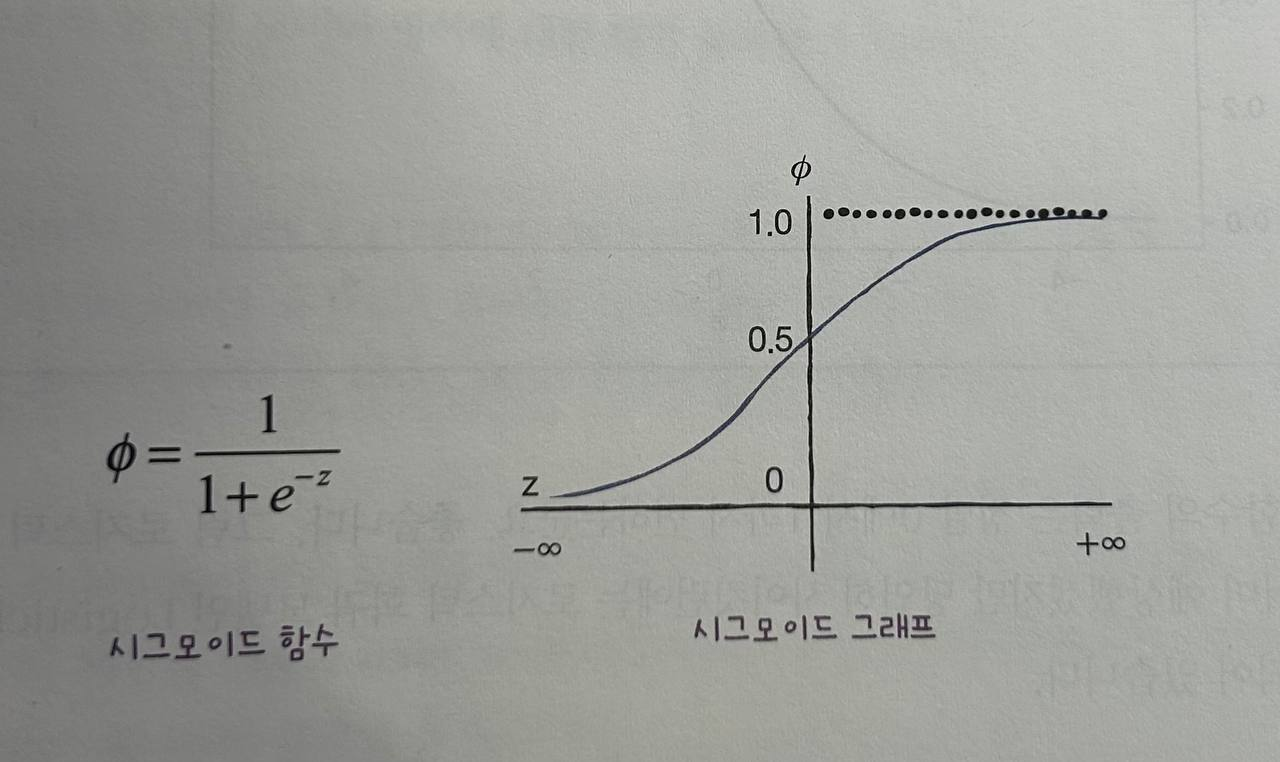

이를 개선하기 위해 **렐루**ReLU 가 제안되었다.

![https://blog.kakaocdn.net/dn/dSBeRe/btq2hZsDw0E/OGSmBIKecK7m18Er0kyDKK/img.png](https://blog.kakaocdn.net/dn/dSBeRe/btq2hZsDw0E/OGSmBIKecK7m18Er0kyDKK/img.png)

렐루 함수는 max(0, z)와 같이 쓸 수 있습니다. 이 함수는 z가 0보다 크면 z를 출력하고 z가 0보다 작으면 0을 출력합니다. 렐루 함수는 특히 이미지 처리에서 좋은 성능을 낸다고 알려져 있습니다. 케라스에서 제공하는 편리한 층 하나를 더 살펴 보겠습니다.

패션 MNIST 데이터는 28 × 28 크기이기 때문에 인공 신경망에 주입하기 위해 넘파이 배열의 reshape() 메서드를 사용해 1차원으로 펼쳤습니다. 직접 이렇게 1차원으로 펼쳐도 좋지만 케라스에서는 이를 위한 Flatten 층을 제공합니다.

In [13]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

이 신경망을 깊이가 3인 신경망이라고 부르지는 않습니다. Flatten 클래스는 학습하는 층이 아니니까요.

In [14]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


첫 번재 등장하는 Flatten 클래스에 포함된 모델 파라미터는 0개입니다.

그럼 훈련 데이터를 다시 준비해서 모델을 훈련해 보겠습니ㅏㄷ.

In [16]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5326 - accuracy: 0.8122
Epoch 2/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3928 - accuracy: 0.8593
Epoch 3/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3561 - accuracy: 0.8717
Epoch 4/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3340 - accuracy: 0.8814
Epoch 5/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3167 - accuracy: 0.8865


시그모이드 함수를 사용했을 때와 비교하면 성능이 조금 향상되었습니다.

In [19]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 690us/step - loss: 0.3925 - accuracy: 0.8685


[0.39253872632980347, 0.8684999942779541]

1절의 은닉층을 추가하지 않을 경우보다 몇 퍼센트 성능이 향상되었네요. 지금까지는 모델을 5번의 에포크 동안 훈련했습니다. 이보다 더 훈련하지 않을 이유가 없겠죠. 그전에 인공 신경망의 하이퍼파라미터에 대해 잠시 알아본다.

## 옵티마이저

여러 개의 은닉층을 추가할 수도 있습니다. 은닉층의 뉴런 개수도 하이퍼파라미터입니다. 또 활성화 함수도 선택해야 할 하이퍼파라미터이다. 심지어 층의 종류도 하이퍼파라미터이다.

케라스 미니배치 개수는 32개 이다. fit() 메서드의 batch_size 매개변수에서 조정할 수 있으며 이 역시 하이퍼파라미터이다. fit() 메서드의 epochs 매개변수도 하이퍼파라미터이다!

마지막으로 compile() 메서드에서는 케라스의 기본 경사 하강법 알고리즘인 RMSprop을 사용했습니다. 케라스는 다양한 종류의 경사 하강법 알고리즘을 제공합니다. 이들을 **옵티마이저**optimizer라고 부릅니다. RMSprop의 학습률 또한 조정할 하이퍼파라미터 중 하나입니다.

여기서는 여러 가지 옵티마이저를 테스트해 보겠습니다. 가장 기본적인 옵티마이저는 확률적 경사 하강법인 SGD입니다.

SGD 옵티마이저를 사용하려면 compile() 메서드의 optimizer 매개변수를 'sgd'로 지정합니다.

만약 SGD 클래스의 학습률 기본값이 0.01일 때 이를 바꾸고 싶다면 다음과 같이 원하는 학습률을 learning_rate 매개변수에 지정하여 사용합니다.
```
sgd = keras.optimizers.SGD(learning_rate=0.1)
```

SGD 외에도 다양한 옵티마이저들이 있습니다.

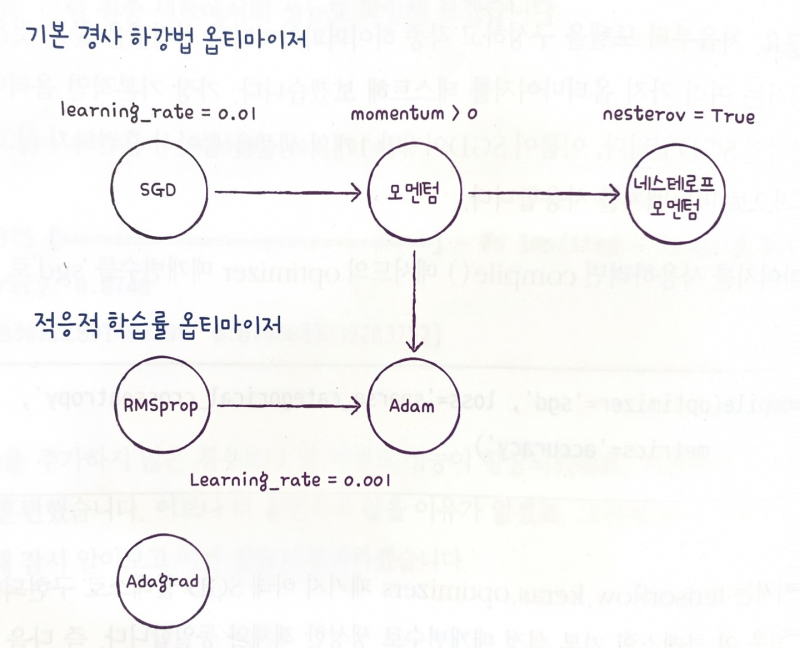

기본 경사 하강법 옵티마이저는 모두 SGD 클래스에서 제공합니다. SGD 클래스의 momentum 매개변수의 기본값은 0입니다. 이를 0보다 큰 값으로 지정하면 마치 이전의 그레이디언트를 가속도처럼 사용하는 **모멘텀 최적화**momentum optimization를 사용합니다. 보통 momentum 매개변수는 0.9이상을 지정합니다.

다음처럼 SGD 클래스의 nesterov 매개변수를 기본값 False에서 True로 바꾸면 **네스테로프 모멘텀 최적화**nesterov momentum optimization를 사용합니다.
```
sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)
```

네스테로프 모멘텀은 모멘텀 최적화를 2번 반복하여 구현합니다. 대부분의 경우 네스테로프 모멘텀 최적화가 기본 확률적 경사 하강법 보다 더 나은 성능을 제공합니다.

모델이 최적점에 가까이 갈수록 학습률을 낮출 수 있습니다. 이렇게 하면 안정적으로 최적점에 수렴할 가능성이 높아집니다. 이런 학습률을 **적응적 학습률**adaptive learning rate이라고 합니다.

적응적 학습률을 사용하는 대표적인 옵티마이저는 Adagrad와 RMSprop입니다. 각각 compile() 메서드의 optimizer 매개변수에 'adagrad'와 'rmsprop'으로 지정할 수 있습니다. optimizer 매개변수의 기본값이 바로 'rmsprop'입니다. 이 두 옵티마이저의 매개변수를 바꾸고 싶다면 SGD와 같이 Adagrad와 RMSprop 클래스 객체를 만들어 사용하면 됩니다.
```
adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='sparse_categorical_crossentropy', metrics='accuracy')
```

모멘텀 최적화와 RMSprop의 장점을 접목한 것이 Adam입니다. 적응적 학습률을 사용하는 이 3개의 클래스는 learning_rate 매개변수의 기본값으로 모두 0.001을 사용합니다.

여기에서는 Adam 클래스의 매개변수 기본값을 사용해 패션 MNIST 모델을 훈련해 보겠습니다.

먼저 모델을 다시 생성합니다.

In [20]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

compile() 메서드의 optimizer를 'adam'으로 설정하고 5번의 에포크 동안 훈련합니다.

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5284 - accuracy: 0.8136
Epoch 2/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3997 - accuracy: 0.8565
Epoch 3/5
1500/1500 [==============================] - 1s 987us/step - loss: 0.3567 - accuracy: 0.8717
Epoch 4/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3308 - accuracy: 0.8801
Epoch 5/5
1500/1500 [==============================] - 1s 987us/step - loss: 0.3094 - accuracy: 0.8845


기본 RMSprop을 사용했을 때와 거의 같은 성능을 보여줍니다. 마지막으로 검증 세트에서의 성능도 확인해 보죠.

In [23]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 702us/step - loss: 0.3417 - accuracy: 0.8758


[0.341695636510849, 0.8757500052452087]

기본 RMSprop보다 조금 더 나은 성능을 냅니다.

## 마무리

### 핵심 포인트

- **심층 신경망**: 2개 이상의 층을 포함한 신경망
- **렐루 함수**: 이미지 분류 모델의 은닉층에서 많이 사용하는 활성화 함수
- **옵티마이저**: 신경망의 가중치와 절편을 학습하기 위한 알고리즘 또는 방법

### 핵심 패키지와 함수

#### TensorFlow

- **add()**: 케라스 모델에 층을 추가하는 메서드
- **summary()**: 케라스 모델의 정보를 출력하는 메서드
- **SGD**: 기본 경사 하강법 옵티마이저 클래스
  learning_rate 매개변수로 학습률 지정하며 기본값 0.01
  momentum 매개변수에 0 이상의 값을 지정하면 모멘텀 최적화 수행
  nesterov 매개변수를 True로 설정하면 네스테로프 모멘텀 최적화 수행
- **Adagrad**: Adagrad 옵티마이저 클래스
  learning_rate 매개변수로 학습률 지정하며 기본값 0.01
  Adagrad는 그레이디언트 제곱을 누적하여 학습률을 나눔. initial_accumulator_value 매개변수에서 누적 초깃값 지정하며 기본값 0.1
- **RMSprop**: MRSprop 옵티마이저 클래스
  learning_rate 매개변수로 학습률 지정하며 기본값 0.001
  Adagrad처럼 그레이디언트 제곱으로 학습률을 나누지만 최근의 그레이디언트를 사용하기 위해 지수 감소를 사용. rho 매개변수에서 감소 비율 지정하며 기본값 0.9
- **Adam**: Adam 옵티마이저 클래스
  learning_rate 매개변수로 학습률 지정하며 기본값 0.001
  모멘텀 최적화에 있는 그레이디언트의 지수 감소 평균을 조절하기 위해 beta_1 매개변수가 있으며 기본값 0.9
  RMSprop에 있는 그레이디언트 제곱의 지수 감소 평균을 조절하기 위해 beta_2 매개변수가 있으며 기본값 0.999